# Experimenting with different types of initialization
For CNNs, the initialization of the weights and biases can be extremely important. For very deep neural networks, some initialization techniques may lead to diminishing gradients caused by the magnitude of the gradient in the final layers. In the following recipe, we will show you how to use different initializations for a well-known network and demonstrate the difference in performance. By picking the right initialization, one can speed up convergence of a network. In the following recipe, we first initialize the weights and bias of the network with the popular Gaussian noise, with the mean equal to zero and a standard deviation of 0.01. Afterwards, we use Xavier initialization, both normal and uniform, and some other popular initialization distributions.

In [1]:
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras import utils, losses, optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D

SEED = 2017

Using TensorFlow backend.


### Loading the filenames and outputting the training set sizes

In [2]:
# Specify data directory and extract all file names for both classes
DATA_DIR = 'data/'
cats = glob.glob(DATA_DIR + "Cat/*.jpg")
dogs = glob.glob(DATA_DIR + "Dog/*.jpg")

print('#Cats: {}, #Dogs: {}'.format(len(cats), len(dogs)))
# #Cats: 12500, #Dogs: 12500

#Cats: 12500, #Dogs: 12500


### Split the data in a training and validation set

In [3]:
dogs_train, dogs_val, cats_train, cats_val = train_test_split(dogs, cats, test_size=0.2, random_state=SEED)

### The training set is relatively large; we will be using a batch generator so that we don't have to load all images in memory

In [4]:
def batchgen(cats, dogs, batch_size, img_size=50):
    # Create empty numpy arrays
    batch_images = np.zeros((batch_size, img_size, img_size, 3))
    batch_label = np.zeros(batch_size)

    # Custom batch generator 
    while 1:
        n = 0
        while n < batch_size:
            # Randomly pick a dog or cat image
            if np.random.randint(2) == 1:
                i = np.random.randint(len(dogs))
                img = cv2.imread(dogs[i])
                if img is None:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # The images have different dimensions, we resize all to 100x100
                img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
                y = 1

            else:
                i = np.random.randint(len(cats))
                img = cv2.imread(cats[i])
                if img is None:
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
                y = 0
        
            batch_images[n] = img
            batch_label[n] = y
            n+=1
        yield batch_images, batch_label

### Define a function that creates a model, given parameters for the stride and padding

In [5]:
def create_model(init_type='xavier', img_size=100):
    # Define architecture
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.) - 0.5, input_shape=(img_size, img_size, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=init_type))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=init_type))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_type))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_type))

    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
 
    sgd = optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
 
    return model

### Define a model for each initialization type

In [6]:
models = []
for init_type in ['random_uniform', 'glorot_normal', 'glorot_uniform', 'lecun_uniform', 'he_uniform']:
    model = create_model(init_type, img_size=50)
    models.append(dict({'setting': '{}'.format(init_type), 
            'model': model
            }))

### Use early stopping to prevent overfitting on the training data

In [7]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', patience=3)]

### Train our models and store the results

In [8]:
batch_size = 512
n_epochs = 500
steps_per_epoch = 100
validation_steps = round((len(dogs_val)+len(cats_val))/batch_size)

train_generator = batchgen(dogs_train, cats_train, batch_size)
val_generator = batchgen(dogs_val, cats_val, batch_size)

history = []
for i in range(len(models)):
    print(models[i])
    history.append(
        models[i]['model'].
        fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=n_epochs, validation_data=val_generator, validation_steps=validation_steps, callbacks=callbacks)
    )

{'setting': 'random_uniform', 'model': <keras.models.Sequential object at 0x7fc1300ac128>}
Epoch 1/500
100/100 [==============================] - 1370s 14s/step - loss: 0.6509 - binary_accuracy: 0.6082 - val_loss: 0.5892 - val_binary_accuracy: 0.6904
Epoch 2/500
100/100 [==============================] - 1197s 12s/step - loss: 0.5637 - binary_accuracy: 0.7121 - val_loss: 0.5344 - val_binary_accuracy: 0.7242
Epoch 3/500
100/100 [==============================] - 896s 9s/step - loss: 0.5147 - binary_accuracy: 0.7496 - val_loss: 0.4934 - val_binary_accuracy: 0.7625
Epoch 4/500
100/100 [==============================] - 895s 9s/step - loss: 0.4751 - binary_accuracy: 0.7754 - val_loss: 0.4671 - val_binary_accuracy: 0.7902
Epoch 5/500
100/100 [==============================] - 859s 9s/step - loss: 0.4469 - binary_accuracy: 0.7938 - val_loss: 0.4577 - val_binary_accuracy: 0.7805
Epoch 6/500
100/100 [==============================] - 857s 9s/step - loss: 0.4100 - binary_accuracy: 0.8146 - val_

100/100 [==============================] - 607s 6s/step - loss: 0.6651 - binary_accuracy: 0.5851 - val_loss: 0.5753 - val_binary_accuracy: 0.7053
Epoch 2/500
100/100 [==============================] - 603s 6s/step - loss: 0.5709 - binary_accuracy: 0.7072 - val_loss: 0.5161 - val_binary_accuracy: 0.7416
Epoch 3/500
100/100 [==============================] - 606s 6s/step - loss: 0.5038 - binary_accuracy: 0.7589 - val_loss: 0.4489 - val_binary_accuracy: 0.7852
Epoch 4/500
100/100 [==============================] - 603s 6s/step - loss: 0.4468 - binary_accuracy: 0.7971 - val_loss: 0.4176 - val_binary_accuracy: 0.8098
Epoch 5/500
100/100 [==============================] - 600s 6s/step - loss: 0.4196 - binary_accuracy: 0.8103 - val_loss: 0.3790 - val_binary_accuracy: 0.8354
Epoch 6/500
100/100 [==============================] - 598s 6s/step - loss: 0.3900 - binary_accuracy: 0.8260 - val_loss: 0.3803 - val_binary_accuracy: 0.8307
Epoch 7/500
100/100 [==============================] - 622s 6s/s

### Visualize the results

Max accuracy model random_uniform: 0.854296875
Max accuracy model glorot_normal: 0.8625
Max accuracy model glorot_uniform: 0.87578125
Max accuracy model lecun_uniform: 0.8654296875
Max accuracy model he_uniform: 0.84296875


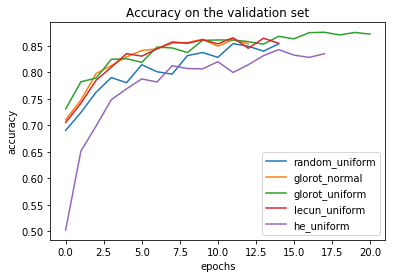

In [9]:
for i in range(len(models)):
    plt.plot(range(len(history[i].history['val_binary_accuracy'])), history[i].history['val_binary_accuracy'], label=models[i]['setting'])
    print('Max accuracy model {}: {}'.format(models[i]['setting'], max(history[i].history['val_binary_accuracy'])))
plt.title('Accuracy on the validation set')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Performance comparison with different initialization settings for the weights

As you can see, the type of initialization of the weights can have an impact on the results. Testing all different initialization methods can be computer expensive, so is often not desired. For CNNs, the default settings of each framework often do a great job. For a 2D convolutional layer, the Glorot uniform distributed weights (also known as Xavier uniform initialization) are generally used as the default.